# Cold Plasma Dispersion Relation

[sds]: ../../api/plasmapy.dispersion.analytical.stix_.stix.rst
[bellan2012]: https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2012JA017856

This notebook discusses the usage of the "cold plasma dispersion relation" given by the funciton [stix()][sds].
A dispersion relation relates the frequency and the wavelength of a wave. In magnentised plasmas due to the magnetic field
such relation becomes very complicated. To make the problem tractable, the so-called cold plasma approximation is used. Within this approximation, the dispersion relation is given by a polynomial equation of a 4th degree:

$N^4 A(\omega_{pe}, \omega_{ce}, \theta) + N^2 B(\omega_{pe}, \omega_{ce}, \theta) + C(\omega_{pe}, \omega_{ce}) = 0$,

where $N=ck/\omega$ is the refractive index. This equation has four roots, which account for two propagating modes in the forward and the backward directions.
The plasma properties and the propagation angle $\theta$ enter through the coefficients $A, B, C$  

In [1]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.constants.si import c

from plasmapy.dispersion.analytical.stix_ import stix
from plasmapy.formulary.frequencies import gyrofrequency, plasma_frequency
from plasmapy.particles import Particle

Let's calculate the refractive index for some angles and different plasma densities using the cold plasma dispersion

In [ ]:
N = 300  # number of different plasma densities
n_i = np.linspace(1e10, 3e17, N) * u.m**-3
w_pe = plasma_frequency(n_i, Particle("e-"))  # plasma frequency
B = 0.06 * u.T
w_ce = gyrofrequency(B, Particle("e-"))
w = 2 * np.pi * 2.45e9 * u.rad / u.s  # a typical microwave frequency
# unitless parameters for plasma density and the magnetic field
X = (w_pe / w) ** 2
Y = w_ce / w
theta = np.array([np.pi / 2, np.pi / 3]) * u.rad  # propagation angle
ions = Particle("p+")


k_arr = np.zeros((2, 4, N), dtype=np.complex128)
for i in range(0, N):
    params = {"theta": theta, "w": w, "ions": ions, "n_i": n_i[i], "B": B}
    k = stix(**params)
    k_arr[:, :, i] = k.value

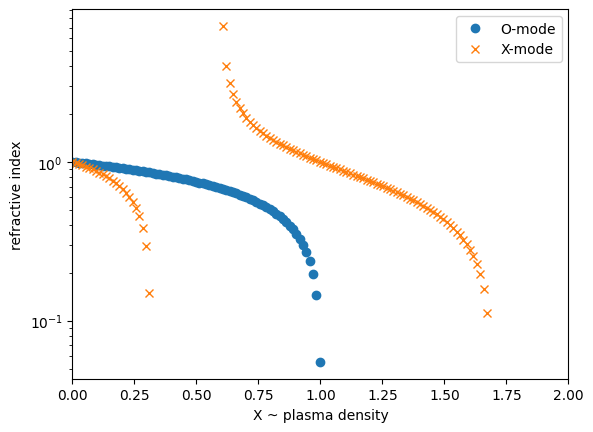

In [ ]:
plt.plot(X, k_arr[1, 0, :].real * c / w, "o", label="O-mode")  # first mode
plt.plot(X, k_arr[1, 2, :].real * c / w, "x", label="X-mode")  # second mode
plt.yscale("log")
plt.xlabel("X ~ plasma density")
plt.ylabel("refractive index")
plt.xlim([0, 2])
plt.legend()

[sds]: ../../api/plasmapy.dispersion.analytical.stix_.stix.rst
Refractive indecies for both modes start at $N = 1$, since in vaccuum ($X=0$), the phase velocity equals to the speed of light.
As $X$ increases, the refractive indecies decrease. When $N = 0$, there is a reflection. For the X-mode, the reflection happens at a low plasma density than for the O-mode. The second branch of the X-mode, has a resonance where $N$ has a singularity. 

Using [stix()][sds], it is possible to find the regions where the plasma waves can propagate and where the reflection and resonance occur.   